# Transfer function

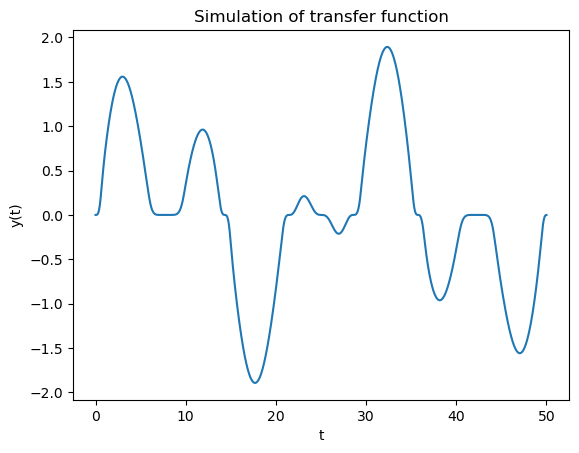

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def y_kp1(y_k, y_km1, u_k):
    return (y_k * y_km1 * u_k + u_k**3 + 0.5 * y_km1) / (1 + y_k**2 + y_km1**2)

dt = 0.01
T = 50
N = int(T / dt)
t = np.linspace(0, T, N)
u = np.sin(2*np.pi*t/25) + np.sin(2*np.pi*t/10)

y_k = np.zeros(N)

for k in range(1, N-1):
    y_k[k+1] = y_kp1(y_k[k], y_k[k-1], u[k-1])

plt.plot(t, y_k)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Simulation of transfer function')
plt.show()

# RBF model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class RadialBasisFunction(nn.Module):
    def __init__(self, input_dim, output_dim, num_neurons):
        super().__init__()

        self.centers = nn.Parameter(torch.rand(input_dim, num_neurons).to(torch.float32))
        self.sigma = nn.Parameter(torch.rand(input_dim, num_neurons).to(torch.float32))

        self.linear = nn.Linear(num_neurons, output_dim)

    def forward(self, x):
        # Compute the RBF kernel
        dists = -torch.pow(x.unsqueeze(-1) - self.centers.unsqueeze(0), 2) / (2 * torch.pow(self.sigma.unsqueeze(0), 2))
        phi = torch.exp(dists.sum(1, keepdim=False))

        # Apply the linear layer
        return self.linear(phi)

In [3]:
# Convert data to PyTorch tensors
y_k_shifted = np.zeros_like(y_k)
y_k_shifted[1:] = y_k[:-1]

X = torch.tensor(np.vstack([y_k_shifted, u]).T).to(torch.float32).view(-1,2)
Y = torch.tensor(y_k).to(torch.float32).view(-1,1)

print(X.shape, Y.shape)
# Define the RBF model
model = RadialBasisFunction(2, 1, 10)

# Train the RBF model
learning_rate = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# All of the data
for epoch in range(100):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, Y)
    loss.backward()
    optimizer.step()

# Data one by one
# for epoch in range(10):
#     for x,y in zip(X, Y):
#         optimizer.zero_grad()
#         output = model(x.view(-1,3))
#         loss = criterion(output, y.view(-1,1))
#         loss.backward()
#         optimizer.step()

# Evaluate the RBF model
with torch.no_grad():
    output = model(X)
    mse = criterion(output, Y).item()

print("MSE:", mse)

torch.Size([5000, 2]) torch.Size([5000, 1])
MSE: 3.836911855614744e-05


### Dataloader

In [4]:
import torch
from torch.utils.data import Dataset,DataLoader

class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


# Convert data to PyTorch tensors
y_k_shifted = np.zeros_like(y_k)
y_k_shifted[1:] = y_k[:-1]

y_k_shifted = np.zeros_like(y_k)
y_k_shifted[1:] = y_k[:-1]

X = torch.tensor(np.vstack([y_k_shifted, u]).T).to(torch.float32).view(-1,2)
Y = torch.tensor(y_k).to(torch.float32).view(-1,1)

print(X.shape, Y.shape)
# Define the RBF model
model = RadialBasisFunction(2, 1, 10)

# Train the RBF model
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

dataloader = DataLoader(MyDataset(X,Y), batch_size=64, shuffle=False)

# All of the data
for epoch in range(100):
    for i, (x,y) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

# Evaluate the RBF model
with torch.no_grad():
    output = model(X)
    mse = criterion(output, Y).item()

print("MSE:", mse)


torch.Size([5000, 2]) torch.Size([5000, 1])
MSE: 0.0008157208212651312


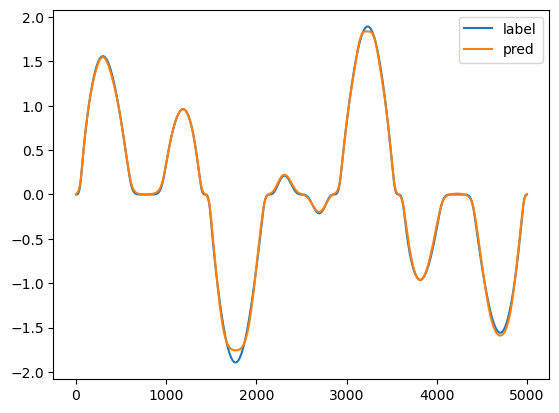

In [5]:
plt.plot(Y.numpy().ravel())
plt.plot(output.numpy().ravel())
plt.legend(['label','pred'])

# RBF Control

### Referece model

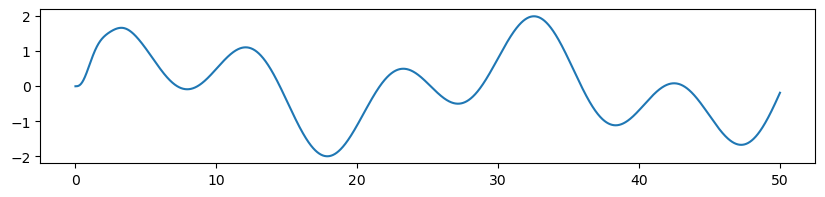

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

w_n = 3.1623
zita = 0.316
K = 1

num = [K]
den = [1/w_n**2, 2*zita/w_n, 1]

transfer_function = ctrl.TransferFunction(num, den)

dt = 0.01
T = 50
N = int(T / dt)
t = np.linspace(0, T, N)
u = np.sin(2*np.pi*t/25) + np.sin(2*np.pi*t/10)

resp = ctrl.forced_response(transfer_function, t, u)
t, output, state = resp.time, resp.outputs, resp.states

u = u.reshape([-1,1])
y_m = output.reshape([-1,1])

plt.figure(figsize=(10,2))
plt.plot(t, y_m)

### MLP

In [7]:
class MLP(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        value = self.fc2(x)
        return value

# Neural Network Tracking Control

In [33]:
from utils.buffer import ReplayBuffer
from utils.plot import plot_return

batch_size = 32
memory = ReplayBuffer(batch_size)

for i in range(batch_size):
    memory.push([0, 0, 0])

# RBF models
learning_rate = 0.1

observer = MLP(2,5)#RadialBasisFunction(2, 1, 10)#
observer_criterion = nn.MSELoss()
observer_optim = torch.optim.Adam(observer.parameters(), lr=learning_rate/10)

controller = MLP(3,5)#RadialBasisFunction(3, 1, 10)#
controller_criterion = nn.MSELoss()
controller_optim = torch.optim.Adam(controller.parameters(), lr=learning_rate)

def y_kp1(y_k, y_km1, u_k):
    return (y_k * y_km1 * u_k + u_k**3 + 0.5 * y_km1) / (1 + y_k**2 + y_km1**2)

loss = []
model_data = []
for i, y_ref in enumerate(y_m):
    u, y_p, y_des = memory.sample(batch_size)
    u, y_p = np.array(u), np.array(y_p)
    
    u_shifted = np.zeros_like(u)
    u_shifted[1:] = u[:-1]

    y_p_shifted = np.zeros_like(y_p)
    y_p_shifted[1:] = y_p[:-1]

    y_ref_array = np.zeros_like(y_p)
    y_ref_array[:] = y_des
    
    # controller input
    cntrl_input = torch.tensor(np.vstack([y_ref_array, y_p, u]).T).to(torch.float32).view(-1,3)
    with torch.no_grad(): u_new = controller(cntrl_input)
    u_new = np.array(u_new).ravel()
    y_p_new = y_kp1(y_p, y_p_shifted, u_new)
    model_data.append([y_ref.item(), y_p_new[-1]])
    
    memory.push([u_new[-1], y_p_new[-1], y_ref.item()])
    
    if len(memory) >= batch_size:
        u, y_p, y_des = memory.sample(len(memory))

        u_shifted = np.zeros_like(u)
        u_shifted[1:] = u[:-1]

        y_p_shifted = np.zeros_like(y_p)
        y_p_shifted[1:] = y_p[:-1]

        y_ref_array = np.zeros_like(y_p)
        y_ref_array[:] = y_des

        obs_input = torch.tensor(np.vstack([y_p_shifted, u]).T).to(torch.float32).view(-1,2)
        obs_label = torch.tensor(y_p).to(torch.float32).view(-1,1)

        cntrl_input = torch.tensor(np.vstack([y_ref_array, y_p, u]).T).to(torch.float32).view(-1,3)
        cntrl_label = torch.tensor(y_ref_array).to(torch.float32).view(-1,1)

        # update observer
        observer_optim.zero_grad()
        y_p_hat = observer(obs_input)
        # print(y_p_hat.shape, obs_label.shape)
        observer_loss = observer_criterion(y_p_hat, obs_label)
        observer_loss.backward()
        observer_optim.step()

        # update controller
        controller_optim.zero_grad()
        u_hat = controller(cntrl_input)
        observer_input = torch.stack([torch.tensor(y_p_shifted).view(-1,1), u_hat.view(-1,1)]).to(torch.float32).view(-1,2)
        y_p_hat = observer(observer_input)
        # print(y_p_hat.shape, u_hat.shape)
        controller_loss = controller_criterion(y_p_hat, cntrl_label)
        controller_loss.backward()
        controller_optim.step()
        loss.append(controller_loss.detach().numpy().ravel())
        # plot_return(loss, f'RBF Controller Loss')

        print(f'Observer: {observer_loss} - Controller: {controller_loss}')



Observer: 0.11845598369836807 - Controller: 0.09443729370832443
Observer: 0.1015356257557869 - Controller: 0.07361052185297012
Observer: 0.08771879971027374 - Controller: 0.05499807000160217
Observer: 0.07801046222448349 - Controller: 0.03915322571992874
Observer: 0.07317845523357391 - Controller: 0.025801852345466614
Observer: 0.0760345384478569 - Controller: 0.01723412610590458
Observer: 0.09186873584985733 - Controller: 0.012453457340598106
Observer: 0.1138022169470787 - Controller: 0.009765060618519783
Observer: 0.15051382780075073 - Controller: 0.012722516432404518
Observer: 0.14817094802856445 - Controller: 0.01570257730782032
Observer: 0.1909559816122055 - Controller: 0.02252781018614769
Observer: 0.20544102787971497 - Controller: 0.02869679406285286
Observer: 0.2108568400144577 - Controller: 0.03637159988284111
Observer: 0.1904333531856537 - Controller: 0.04530256614089012
Observer: 0.18132451176643372 - Controller: 0.053499985486269
Observer: 0.1566995531320572 - Controller: 0

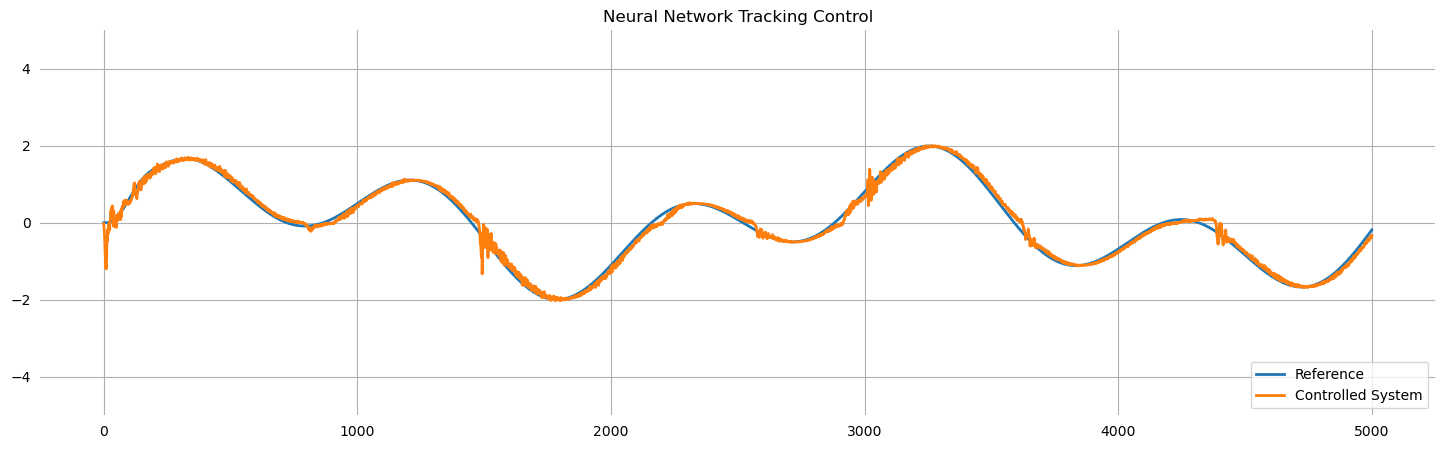

In [34]:
model_data = np.array(model_data)

plt.figure(figsize=(18, 5))
plt.plot(model_data[:, 0], linewidth=2)
plt.plot(model_data[:, 1], linewidth=2)
plt.grid()
plt.title('Neural Network Tracking Control')
plt.legend(['Reference', 'Controlled System'], loc='lower right')
plt.ylim([-5, 5])

# Get current axes
ax = plt.gca()

# Remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Optionally, remove the ticks as well
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Show the plot
plt.show()

### RBF

In [28]:
from utils.buffer import ReplayBuffer
from utils.plot import plot_return

batch_size = 32
memory = ReplayBuffer(batch_size)

for i in range(batch_size):
    memory.push([0, 0])

# RBF models
learning_rate = 0.1

observer = RadialBasisFunction(2, 1, 5)#
observer_criterion = nn.MSELoss()
observer_optim = torch.optim.Adam(observer.parameters(), lr=learning_rate/5)

controller = RadialBasisFunction(3, 1, 5)#
controller_criterion = nn.MSELoss()
controller_optim = torch.optim.Adam(controller.parameters(), lr=learning_rate)

def y_kp1(y_k, y_km1, u_k):
    return (y_k * y_km1 * u_k + u_k**3 + 0.5 * y_km1) / (1 + y_k**2 + y_km1**2)

loss = []
model_data = []
for i, y_ref in enumerate(y_m[:2000]):
    u, y_p = memory.sample(batch_size)
    u, y_p = np.array(u), np.array(y_p)
    
    u_shifted = np.zeros_like(u)
    u_shifted[1:] = u[:-1]

    y_p_shifted = np.zeros_like(y_p)
    y_p_shifted[1:] = y_p[:-1]

    y_ref_array = np.zeros_like(y_p)
    y_ref_array[:] = y_ref
    
    # controller input
    cntrl_input = torch.tensor(np.vstack([y_ref_array, y_p, u]).T).to(torch.float32).view(-1,3)
    with torch.no_grad(): u_new = controller(cntrl_input)
    u_new = np.array(u_new).ravel()
    y_p_new = y_kp1(y_p, y_p_shifted, u_new)
    model_data.append([y_ref[-1], y_p_new[-1]])
    
    memory.push([u_new[-1], y_p_new[-1]])
    
    if len(memory) >= batch_size:
        u, y_p = memory.sample(len(memory))

        u_shifted = np.zeros_like(u)
        u_shifted[1:] = u[:-1]

        y_p_shifted = np.zeros_like(y_p)
        y_p_shifted[1:] = y_p[:-1]

        y_ref_array = np.zeros_like(y_p)
        y_ref_array[:] = y_ref

        obs_input = torch.tensor(np.vstack([y_p_shifted, u]).T).to(torch.float32).view(-1,2)
        obs_label = torch.tensor(y_p).to(torch.float32).view(-1,1)

        cntrl_input = torch.tensor(np.vstack([y_ref_array, y_p, u]).T).to(torch.float32).view(-1,3)
        cntrl_label = torch.tensor(y_ref_array).to(torch.float32).view(-1,1)

        # update observer
        observer_optim.zero_grad()
        y_p_hat = observer(obs_input)
        # print(y_p_hat.shape, obs_label.shape)
        observer_loss = observer_criterion(y_p_hat, obs_label)
        observer_loss.backward()
        observer_optim.step()

        # update controller
        controller_optim.zero_grad()
        u_hat = controller(cntrl_input)
        observer_input = torch.stack([torch.tensor(y_p_shifted).view(-1,1), u_hat.view(-1,1)]).to(torch.float32).view(-1,2)
        y_p_hat = observer(observer_input)
        # print(y_p_hat.shape, u_hat.shape)
        controller_loss = controller_criterion(y_p_hat, cntrl_label)
        controller_loss.backward()
        controller_optim.step()
        loss.append(controller_loss.detach().numpy().ravel())
        # plot_return(loss, f'RBF Controller Loss')

        print(f'Observer: {observer_loss} - Controller: {controller_loss}')



Observer: 0.24744448065757751 - Controller: 0.18891823291778564
Observer: 0.19587442278862 - Controller: 0.13582579791545868
Observer: 0.1487705558538437 - Controller: 0.10680365562438965
Observer: 0.11256595700979233 - Controller: 0.08518368750810623
Observer: 0.09993299841880798 - Controller: 0.06796754151582718
Observer: 0.11734271049499512 - Controller: 0.054631300270557404
Observer: 0.148021399974823 - Controller: 0.04400337114930153
Observer: 0.2407539188861847 - Controller: 0.03748675063252449
Observer: 0.3678181767463684 - Controller: 0.03170480579137802
Observer: 0.4857982099056244 - Controller: 0.03044278360903263
Observer: 0.6616045236587524 - Controller: 0.03036290407180786
Observer: 0.6629149913787842 - Controller: 0.030556246638298035
Observer: 0.7675623893737793 - Controller: 0.02983389049768448
Observer: 0.9180949330329895 - Controller: 0.03281278535723686
Observer: 0.9145591855049133 - Controller: 0.0374281071126461
Observer: 0.9074451923370361 - Controller: 0.03896055

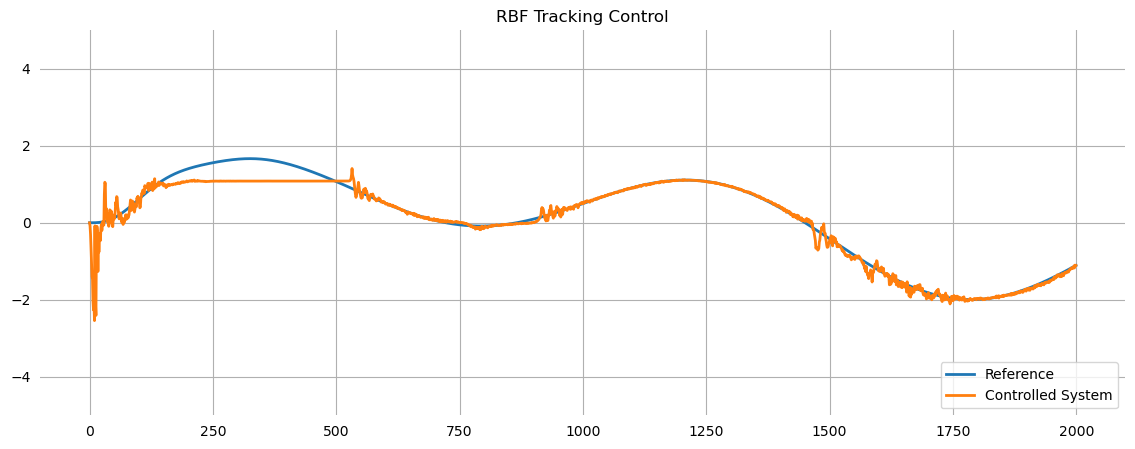

In [29]:
model_data = np.array(model_data)

plt.figure(figsize=(14, 5))
plt.plot(model_data[:, 0], linewidth=2)
plt.plot(model_data[:, 1], linewidth=2)
plt.grid()
plt.title('RBF Tracking Control')
plt.legend(['Reference', 'Controlled System'], loc='lower right')
plt.ylim([-5, 5])

# Get current axes
ax = plt.gca()

# Remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Optionally, remove the ticks as well
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Show the plot
plt.show()